<a href="https://colab.research.google.com/github/unt-iialab/INFO5731_Spring2020/blob/master/Assignments/INFO5731_Assignment_Three.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment Three**

In this assignment, you are required to conduct information extraction, semantic analysis based on **the dataset you collected from assignment two**. You may use scipy and numpy package in this assignment.

# **Question 1: Understand N-gram**

(45 points). Write a python program to conduct N-gram analysis based on the dataset in your assignment two:

(1) Count the frequency of all the N-grams (N=3).

(2) Calculate the probabilities for all the bigrams in the dataset by using the fomular count(w2 w1) / count(w2). For example, count(really like) / count(really) = 1 / 3 = 0.33.

(3) Extract all the **noun phrases** and calculate the relative probabilities of each review in terms of other reviews (abstracts, or tweets) by using the fomular frequency (noun phrase) / max frequency (noun phrase) on the whole dataset. Print out the result in a table with column name the all the noun phrases and row name as all the 100 reviews (abstracts, or tweets).


In [15]:
#Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
from nltk import pos_tag, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import string
import seaborn as sns
from nltk.tree import Tree
import nltk
from nltk.chunk import ne_chunk
from nltk.corpus import stopwords
import pandas as pd


In [16]:
df= pd.read_csv("mve_review.csv")
df.head()

,Movie Reviews
0,One of the most anticipated films of the year ...
1,You'll have to have your wits about you and yo...
2,I'm a big fan of Nolan's work so was really lo...
3,"""Oppenheimer"" is a biographical thriller film ..."
4,This movie is just... wow! I don't think I hav...


In [17]:
# Creating a function to handle the preprocessing and cleaning of a review.
def text_cleaning_and_preprocessing(text):
    # Exclude punctuation marks and special characters.
    text = ''.join([char for char in text if char not in string.punctuation])
    # Exclude numerical characters.
    text = ''.join([char for char in text if not char.isdigit()])
    # Tokenize the text into individual words.
    words = nltk.word_tokenize(text)
    # Remove stop words.
    words = [w for w in words if w.lower() not in stopwords.words('english')] 
    # Convert all words to lowercase.
    words = [w.lower() for w in words]  
    # Stemming words to their root form.
    stemmer = PorterStemmer()
    words = [stemmer.stem(w) for w in words]    
    # Lemmatization to reduce words to their base form.
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]
    # Join the cleaned words to form a refined sentence.
    cleaned_text = ' '.join(words) 
    return cleaned_text

df['Movie Reviews'] = df['Movie Reviews'].apply(text_cleaning_and_preprocessing)


### (1) Count the frequency of all the N-grams (N=3).

In [18]:
# Extracting the 'Movie Reviews' column
movie_reviews = df['Movie Reviews']

# Create an instance of the CountVectorizer class for N-gram analysis (N = 3).
ngram_vectorizer = CountVectorizer(ngram_range=(3, 3))

# Fit and transform the movie reviews
ngram_matrix = ngram_vectorizer.fit_transform(movie_reviews)

# Retrieve the names of the features (trigrams).
trigram_names = ngram_vectorizer.get_feature_names_out()

# Calculate the total counts of each N-gram across all movie reviews.
ngram_frequencies = ngram_matrix.sum(axis=0).A1

# Create a DataFrame to present the analysis results.
result_df = pd.DataFrame({'Trigram': trigram_names, 'Frequency': ngram_frequencies})

# Sort the DataFrame columns in descending order based on frequency.
result_df = result_df.sort_values(by='Frequency', ascending=False)

# Displaying the results
result_df


,Trigram,Frequency
3712,robert downey jr,400
435,blunt florenc pugh,200
1115,emili blunt florenc,150
1640,gener lesli grove,150
1027,downey jr emili,150
...,...,...
1659,get better feel,50
1658,get base true,50
1657,get away nonattent,50
1656,germani return america,50


### (2) Calculate the probabilities for all the bigrams in the dataset by using the fomular count(w2 w1) / count(w2). For example, count(really like) / count(really) = 1 / 3 = 0.33.


In [19]:
# Extracting the 'Movie Reviews' column
user_reviews = df['Movie Reviews']

# Creating an instance of the CountVectorizer class for bigram analysis with a window size of 2
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2))

# Fitting and transforming the data
bigram_matrix = bigram_vectorizer.fit_transform(user_reviews)

# Retrieving the feature names (bigrams)
bigram_features = bigram_vectorizer.get_feature_names_out()

# Calculating the total count of each bigram across all reviews
bigram_counts_total = bigram_matrix.sum(axis=0).A1

# Creating a DataFrame to store the bigram counts
bigram_data = pd.DataFrame({'Bigram': bigram_features, 'Count': bigram_counts_total})

# Calculating the probability using the formula count(w2 w1) / count(w2)
bigram_data['Probability'] = bigram_data['Count'] / bigram_data['Count'].groupby(bigram_data['Bigram'].str.split().str[1]).transform('sum')

# Displaying the output
bigram_data[['Bigram', 'Probability']]


,Bigram,Probability
0,abl get,0.050000
1,abl tackl,0.250000
2,abli support,0.250000
3,abomb chiefli,1.000000
4,abomb project,0.100000
...,...,...
4642,your engag,0.250000
4643,your go,0.058824
4644,your honest,1.000000
4645,your invest,0.250000


### (3) Extract all the noun phrases and calculate the relative probabilities of each review in terms of other reviews (abstracts, or tweets) by using the fomular frequency (noun phrase) / max frequency (noun phrase) on the whole dataset. Print out the result in a table with column name the all the noun phrases and row name as all the 100 reviews (abstracts, or tweets).

In [20]:
df= pd.read_csv("mve_review.csv")
df.head()

,Movie Reviews
0,One of the most anticipated films of the year ...
1,You'll have to have your wits about you and yo...
2,I'm a big fan of Nolan's work so was really lo...
3,"""Oppenheimer"" is a biographical thriller film ..."
4,This movie is just... wow! I don't think I hav...


In [22]:
df['Movie Reviews'] = df['Movie Reviews'].apply(text_cleaning_and_preprocessing)

from nltk import pos_tag, word_tokenize, RegexpParser

# Extracting the 'Movie Reviews' column
user_reviews = df['Movie Reviews']

In [23]:
from nltk import pos_tag, word_tokenize
from nltk.chunk import RegexpParser

# A function to extract noun phrases from a given review.
def extract_noun_phrases(input_review):
    # Tokenize words in the review
    words = word_tokenize(input_review)   
    # Perform part-of-speech tagging on the tokenized words
    pos_tags = pos_tag(words)   
    # Define a chunking pattern for identifying noun phrases
    chunk_pattern = "NP: {<DT>?<JJ>*<NN>}"
    chunk_parser = RegexpParser(chunk_pattern)   
    # Apply the chunk parser to the part-of-speech tagged words
    tree = chunk_parser.parse(pos_tags)    
    # Extract noun phrases from the parsed tree
    noun_phrases = []
    for subtree in tree.subtrees(filter=lambda t: t.label() == 'NP'):
        phrase = " ".join([word for word, pos in subtree.leaves()])
        noun_phrases.append(phrase)
    
    return noun_phrases


In [24]:
# Applying the N_phrases function to each review
all_noun_phrases = user_reviews.apply(extract_noun_phrases)

In [25]:
# Combine all unique noun phrases into a single list.
distinct_noun_phrases = list(set([phrase for phrase_list in all_noun_phrases for phrase in phrase_list]))


In [26]:
# Creating an object for noun phrase analysis using a customized vocabulary
custom_vectorizer = CountVectorizer(vocabulary=distinct_noun_phrases)

In [27]:
# Fit and transform the reviews to determine the frequency of each noun phrase
noun_phrase_matrix = custom_vectorizer.fit_transform(user_reviews )


In [28]:
# Generating a DataFrame from a matrix
result_dataframe = pd.DataFrame(noun_phrase_matrix .toarray(), columns=distinct_noun_phrases )


In [29]:

# Calculating normalized probabilities for each observation
normalized_probabilities = result_dataframe.div(result_dataframe.max(axis=1), axis=0)

# Displaying the head of the DataFrame with relative probabilities
normalized_probabilities.head()

,subject opinion,littl screen,great see,enough emot,christoph nolan,futur,much last night,support,instanc,felt,...,tell,question,brilliant especi moment,ad,realli second,histori,half hour,break german code,perfect balanc,decad
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.111111,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.333333,0.0,0.000000,0.0,0.0,0.0,0.333333
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.041667,0.083333,0.0,0.000000,0.0,0.125000,0.0,0.0,0.0,0.041667
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000


# **Question 2: Undersand TF-IDF and Document representation**

(20 points). Starting from the documents (all the reviews, or abstracts, or tweets) collected for assignment two, write a python program:

(1) To build the **documents-terms weights (tf*idf) matrix bold text**.

(2) To rank the documents with respect to query (design a query by yourself, for example, "An Outstanding movie with a haunting performance and best character development") by using **cosine similarity**.

In [30]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
df = pd.read_csv("mve_review.csv")
df.head()

,Movie Reviews
0,One of the most anticipated films of the year ...
1,You'll have to have your wits about you and yo...
2,I'm a big fan of Nolan's work so was really lo...
3,"""Oppenheimer"" is a biographical thriller film ..."
4,This movie is just... wow! I don't think I hav...


In [32]:
df['Movie Reviews'] = df['Movie Reviews'].apply(text_cleaning_and_preprocessing)

In [33]:
# Defining a search query for movie recommendations
user_search_query ="An Outstanding movie with a haunting performance and best character development "


In [34]:
# Concatenate the existing reviews with the new inquiry
documents = df['Movie Reviews'].tolist()
documents.append(user_search_query)

In [35]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
    
# Compute the TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)


tfidf_matrix

<1251x1786 sparse matrix of type '<class 'numpy.float64'>'
	with 184960 stored elements in Compressed Sparse Row format>

In [36]:

query_vector = tfidf_matrix[-1]
document_vectors = tfidf_matrix[:-1]

# Compute cosine similarities between the query and each document
query_doc_cosine_similarities = cosine_similarity(query_vector, document_vectors)

query_doc_cosine_similarities

array([[0.00343135, 0.00221038, 0.        , ..., 0.00208641, 0.        ,
        0.        ]])

In [37]:
# Create a DataFrame to store document indices and their corresponding cosine similarity.
cosine_similarity_df = pd.DataFrame({
    'Documents': range(1, len(documents)),
    'Cosine Similarity': query_doc_cosine_similarities[0]
})



In [38]:
# Sorting the documents based on their cosine similarity scores in descending order.
sorted_documents = cosine_similarity_df.sort_values(by='Cosine Similarity', ascending=False)

# Displaying the ranked documents.
print("Ranked Documents:")
sorted_documents


Ranked Documents:


,Documents,Cosine Similarity
114,115,0.006486
689,690,0.006486
1064,1065,0.006486
839,840,0.006486
239,240,0.006486
...,...,...
746,747,0.000000
743,744,0.000000
187,188,0.000000
188,189,0.000000


# **Question 3: Create your own word embedding model**

(20 points). Use the data you collected for assignment two to build a word embedding model:

(1) Train a 300-dimension word embedding (it can be word2vec, glove, ulmfit, bert, or others).

(2) Visualize the word embedding model you created.

Reference: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

Reference: https://jaketae.github.io/study/word2vec/

In [39]:
pip install --upgrade gensim

Note: you may need to restart the kernel to use updated packages.


In [40]:
from gensim.models import Word2Vec
import pandas as pd
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')  # Download the punkt tokenizer

# Load your CSV file into a DataFrame
df = pd.read_csv('mve_review.csv')

# Tokenize the movie reviews
tokenized_reviews = [word_tokenize(review) for review in df['Movie Reviews']]

# Train Word2Vec model
embedding_size = 300
word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=embedding_size, window=5, min_count=1, workers=4)



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mounicatamalampudi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [41]:
print(word2vec_model)

Word2Vec<vocab=2460, vector_size=300, alpha=0.025>


In [61]:
# Access vectors for all words in the vocabulary
X = [new_model.wv.get_vector(word) for word in new_model.wv.index_to_key]


In [62]:
# Access vectors for all words in the vocabulary
X = [new_model.wv.get_vector(word) for word in new_model.wv.index_to_key]


In [63]:
import numpy as np

X = np.array(X)

In [64]:
X 

array([[-7.3718801e-02, -2.8908303e-01,  1.3641879e-04, ...,
        -1.2141493e-01,  1.8667883e-01, -2.3825487e-01],
       [-5.0106764e-01,  5.0855482e-01,  2.9688779e-01, ...,
        -8.8919736e-02, -4.6171507e-01, -4.2673716e-01],
       [ 4.2565173e-01, -4.6675050e-01,  1.7221692e-01, ...,
         5.7100016e-01,  1.3374613e-01,  2.7966473e-01],
       ...,
       [ 1.6671877e-01, -1.2801966e-01,  1.2469897e-01, ...,
         2.0367272e-01,  4.3663725e-01, -1.4603324e-01],
       [ 3.7571281e-02, -2.1674193e-02,  9.7627893e-02, ...,
         2.6879424e-01,  2.5294369e-01,  8.9873401e-03],
       [-1.0835945e-01,  3.5716990e-01,  1.0810927e-02, ...,
         1.4947617e-01, -3.5318125e-02, -1.1356515e-01]], dtype=float32)

In [65]:
import pandas as pd
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')  # Download the punkt tokenizer

# Load your CSV file into a DataFrame
df = pd.read_csv('mve_review.csv')

# Tokenize the movie reviews
tokenized_reviews = [word_tokenize(review) for review in df['Movie Reviews']]

# Train Word2Vec model
embedding_size = 300
word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=embedding_size, window=5, min_count=1, workers=4)

# Save the trained model to a file
word2vec_model.save('word2vec_model.bin')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mounicatamalampudi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


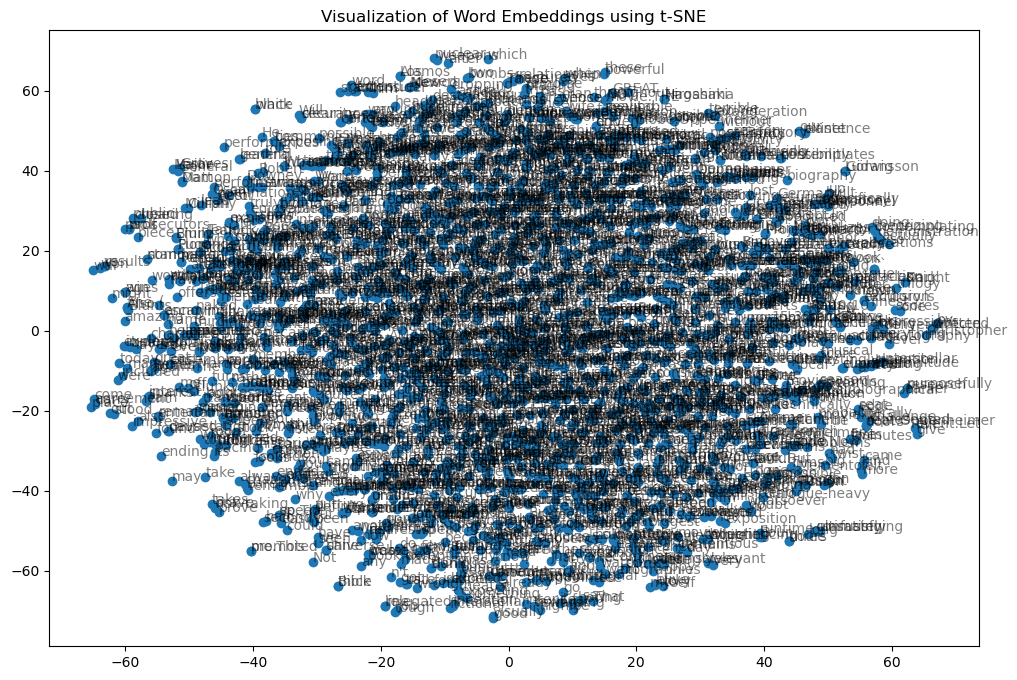

In [68]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np  # Import NumPy for array operations

# Load the Word2Vec model
word2vec_model = Word2Vec.load('word2vec_model.bin')

# Get the embeddings and corresponding words
embeddings = [word2vec_model.wv[word] for word in word2vec_model.wv.index_to_key]
words = [word for word in word2vec_model.wv.index_to_key]

# Convert the list of embeddings to a NumPy array
embeddings_array = np.array(embeddings)

# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_array)

# Create a DataFrame for visualization
df_vis = pd.DataFrame({'word': words, 'x': embeddings_2d[:, 0], 'y': embeddings_2d[:, 1]})

# Plot the word embeddings
plt.figure(figsize=(12, 8))
plt.scatter(df_vis['x'], df_vis['y'])
for i, word in enumerate(df_vis['word']):
    plt.annotate(word, (df_vis['x'].iloc[i], df_vis['y'].iloc[i]), alpha=0.5)

plt.title('Visualization of Word Embeddings using t-SNE')
plt.show()


## Alternate Approach

In [42]:
# summarize vocabulary
words = list(word2vec_model.wv.index_to_key)
print(words)


['the', ',', '.', 'of', 'and', 'a', 'to', 'is', 'in', 'I', "'s", 'it', 'that', 'Oppenheimer', 'for', 'his', 'Nolan', 'this', 'film', 'was', 'on', 'with', 'movie', 'as', 'he', 'but', 'one', 'not', 'The', "n't", 'an', 'be', 'are', "''", '``', 'have', 'at', 'like', 'or', 'you', 'by', 'all', 'time', 'really', 'about', ')', 'me', '(', 'also', 'from', 'very', 'story', 'so', 'best', 'more', 'do', 'can', 'there', 'we', 'just', 'much', 'It', 'could', '!', 'long', 'when', 'Robert', 'Murphy', 'get', 'which', 'some', 'what', 'most', 'no', 'has', 'too', 'good', 'feel', 'will', 'way', 'still', 'bomb', 'first', 'movies', 'Christopher', 'into', 'watch', 'him', 'scenes', 'if', 'did', 'great', 'who', 'had', 'us', 'Downey', 'even', 'any', 'my', 'better', 'other', 'its', 'their', 'been', '-', 'than', 'many', 'where', 'scene', 'something', 'these', 'after', 'because', 'know', 'This', 'were', 'man', 'life', 'work', 'see', 'while', 'Blunt', 'IMAX', 'acting', 'performance', 'But', 'Emily', 'sound', 'say', 'wo

In [43]:
# save model
word2vec_model.save('model.bin')

In [44]:
new_model = Word2Vec.load('model.bin')
print(new_model)

Word2Vec<vocab=2460, vector_size=300, alpha=0.025>


In [45]:
# Access vectors for all words in the vocabulary
X = [new_model.wv.get_vector(word) for word in new_model.wv.index_to_key]


In [46]:
import numpy as np

X = np.array(X)

In [47]:
X 

array([[-7.3718801e-02, -2.8908303e-01,  1.3641879e-04, ...,
        -1.2141493e-01,  1.8667883e-01, -2.3825487e-01],
       [-5.0106764e-01,  5.0855482e-01,  2.9688779e-01, ...,
        -8.8919736e-02, -4.6171507e-01, -4.2673716e-01],
       [ 4.2565173e-01, -4.6675050e-01,  1.7221692e-01, ...,
         5.7100016e-01,  1.3374613e-01,  2.7966473e-01],
       ...,
       [ 1.6671877e-01, -1.2801966e-01,  1.2469897e-01, ...,
         2.0367272e-01,  4.3663725e-01, -1.4603324e-01],
       [ 3.7571281e-02, -2.1674193e-02,  9.7627893e-02, ...,
         2.6879424e-01,  2.5294369e-01,  8.9873401e-03],
       [-1.0835945e-01,  3.5716990e-01,  1.0810927e-02, ...,
         1.4947617e-01, -3.5318125e-02, -1.1356515e-01]], dtype=float32)

In [48]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
result = pca.fit_transform(X)

In [49]:
import matplotlib.pyplot as plt

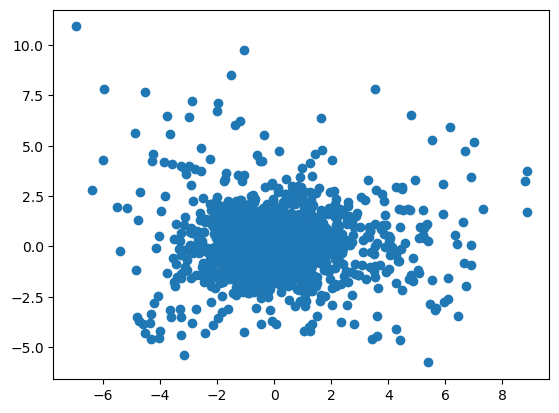

In [50]:
plt.scatter(result[:, 0], result[:, 1])

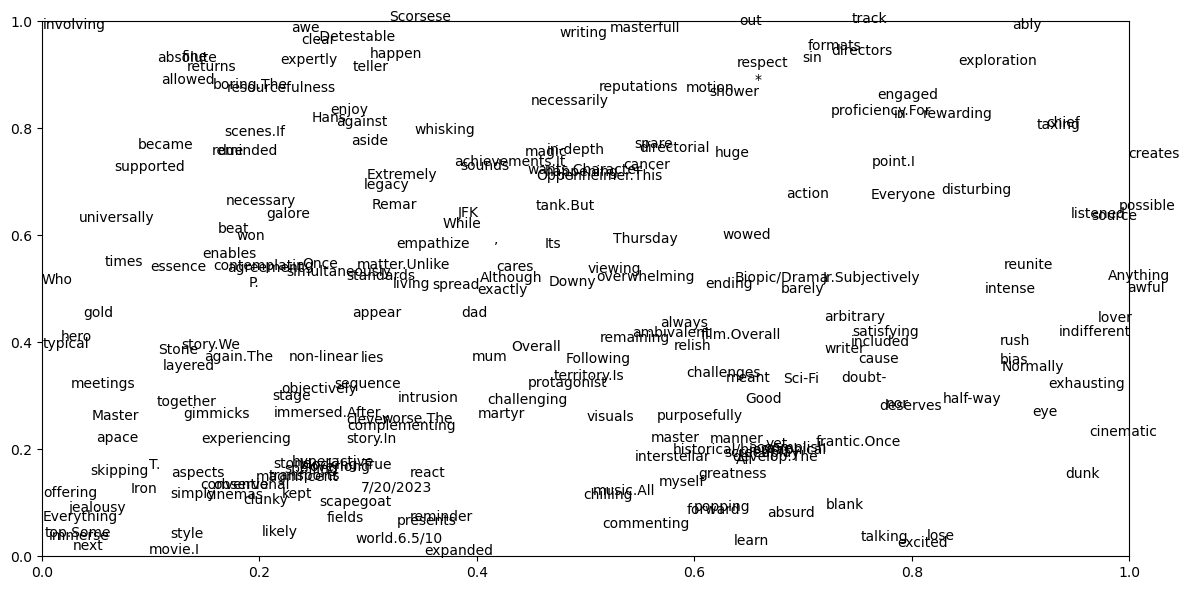

In [51]:
# Annotate words on the scatter plot
plt.figure(figsize=(12,6))
words = list(new_model.wv.index_to_key)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.tight_layout()
plt.show()


# **Question 4: Create your own training and evaluation data for sentiment analysis**

(15 points). **You dodn't need to write program for this question!** Read each review (abstract or tweet) you collected in detail, and annotate each review with a sentiment (positive, negative, or neutral). Save the annotated dataset into a csv file with three columns (first column: document_id, clean_text, sentiment), upload the csv file to GitHub and submit the file link blew. This datset will be used for assignment four: sentiment analysis and text classification.


### The GitHub link of your final csv file

### Link:

https://github.com/mounicahandana/MounicaSiriChandana_INFO5731_Fall2023/blob/main/oppenheimer_Annotated_reviews.csv

